# Постановка задачи

В рамках `ML_based_approach` были рассмотрены методы машинного обучения для задачи бинарной классификации.

В текущем ноутбуке будут рассмотрены нейронные сети для предсказания новостей. Хоть данных не очень много, стоит посмотреть, справится ли полносвязная нейронная сеть с поставленной задачей.

# Импорт библиотек и считывание данных

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import copy
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

Как и ранее, `test.csv` используем только для финальных предсказаний

In [ ]:
df_train = pd.read_csv('data/train.csv', sep='\t')
df_train.head(3)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1


# Предобработка данных и разделение на train и val

In [ ]:
X = df_train['title']
y = df_train['is_fake'].values

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X).toarray()

# переводим в тензоры
X_tfidf = torch.tensor(X_tfidf, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# делим на train и val
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Полносвязная нейронная сеть

In [ ]:
class FC_NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_classes = 5000

        self.model = nn.Sequential(
            nn.Linear(self.n_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        outp = self.model(x)
        return outp.reshape(-1)

# Функция для обучения

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_FC(model, loss_fn, opt, n_epochs, batch_size, lr, X_train, y_train,
             X_val=None, y_val=None):

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = None
    if X_val is not None and y_val is not None:
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = opt(model.parameters(), lr=lr)

    best_f1 = -np.inf
    best_weights = None
    loss_history = []
    roc_auc_history = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        y_pred_all = []
        y_true_all = []

        with tqdm.notebook.tqdm(train_loader, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for X_batch, y_batch in train_loader:
                # Forward
                y_pred = model(X_batch.to(device))
                loss = loss_fn(y_pred, y_batch.to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # loss и F1 macro
                epoch_loss += loss.item()
                y_pred_all.extend(y_pred.round().detach().cpu().numpy())
                y_true_all.extend(y_batch.detach().cpu().numpy())

                bar.set_postfix(
                    loss=loss.item(),
                    f1=f1_score(y_true_all, y_pred_all, average='macro')
                )
                bar.update(1)

        epoch_loss /= len(train_loader.dataset)
        loss_history.append(epoch_loss)

        # для ROC AUC
        y_pred_proba = torch.sigmoid(torch.tensor(y_pred_all)).numpy()
        roc_auc = roc_auc_score(y_true_all, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_true_all, y_pred_proba)
        roc_auc_history.append(roc_auc)

        # валидация
        if val_loader is not None:
            model.eval()
            y_pred_all_val = []
            y_true_all_val = []
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    y_val_pred = model(X_val_batch.to(device))
                    y_pred_all_val.extend(y_val_pred.round().detach().cpu().numpy())
                    y_true_all_val.extend(y_val_batch.detach().cpu().numpy())

            val_f1 = f1_score(y_true_all_val, y_pred_all_val, average='macro')
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_weights = copy.deepcopy(model.state_dict())
            if val_f1 > 0.98: # если достигли высокого F1
                break

    # восстанавливаем модель с лучшими весами
    if best_weights is not None:
        model.load_state_dict(best_weights)

    # ROC кривая
    plt.figure()
    plt.plot(fpr, tpr, color='coral', lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title("ROC")
    plt.legend(loc="lower right")
    plt.show()

    return model, loss_history

# Обучение модели

Рассмотрим Adam, SGD и RMSProp, поэкспериментируем с learning rate

### RMSProp

In [ ]:
model = FC_NeuralNetwork()
loss_fn = nn.BCELoss()
optimizer = torch.optim.RMSprop
n_epochs = 10
batch_size = 32
lr=3e-2

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

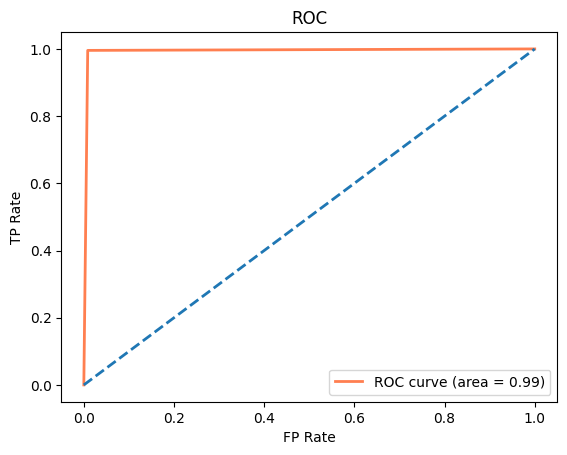

In [ ]:
model_RMSProp, loss_RMSProp = train_FC(model, loss_fn, optimizer, n_epochs, batch_size, lr, X_train, y_train, X_val, y_val)

### Adam

In [ ]:
model = FC_NeuralNetwork()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam
n_epochs = 10
batch_size = 32
lr=4e-2

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

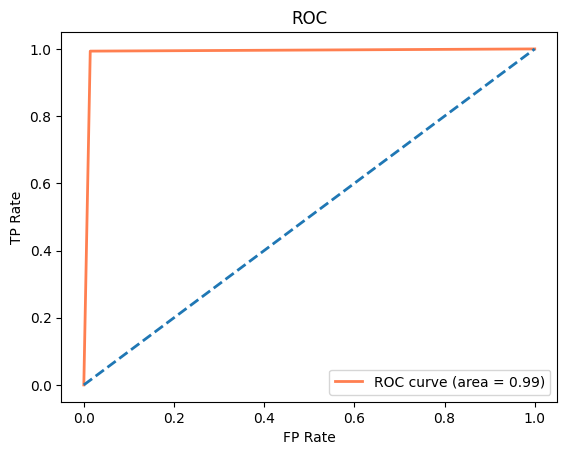

In [ ]:
model_adam, loss_adam = train_FC(model, loss_fn, optimizer, n_epochs, batch_size, lr, X_train, y_train, X_val, y_val)

# SGD

In [ ]:
model = FC_NeuralNetwork()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD
n_epochs = 10
batch_size = 32
lr=4e-2

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

  0%|          | 0/144 [00:00<?, ?batch/s]

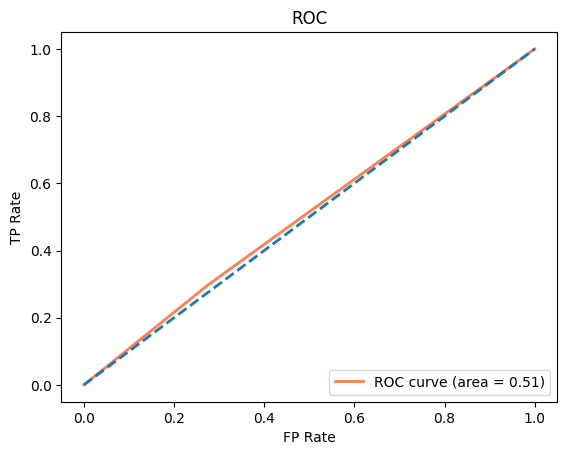

In [ ]:
model_SGD, loss_SGD = train_FC(model, loss_fn, optimizer, n_epochs, batch_size, lr, X_train, y_train, X_val, y_val)

SGD справился плохо, но так обычно и происходит, не самый лучший оптимайзер

# Графики лоссов

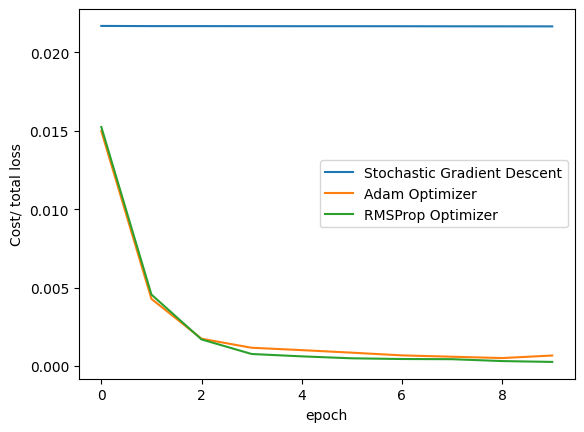

In [ ]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_adam, label = "Adam Optimizer")
plt.plot(loss_RMSProp, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

Незначительно, но RMSProp все же лучше (ориентируясь на совокупность метрики f1-macro и график лоссов)

Поэтому осуществим предсказания с использованием `model_RMSProp`

#### сохраняем лучшую модель

In [ ]:
torch.save(model_RMSProp, 'model_RMSProp.pth')

# Предсказание классов для test.csv

In [ ]:
df_test= pd.read_csv('data/test.csv', sep='\t')
df_test.head(3)

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_test_tfidf = tfidf.fit_transform(df_test['title']).toarray()


X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)

model_RMSProp.eval()
with torch.no_grad():
    predictions = model_RMSProp(X_test_tensor.to(device))

predicted_probs = predictions

predicted_labels = (predicted_probs > 0.5).int()

In [ ]:
len(predicted_probs) == len(predicted_labels)

True

In [ ]:
df_test['prob_fake'] = predicted_probs
df_test['is_fake'] = predicted_labels
# predictions.csv
df_test.to_csv('predictions.csv', sep='\t', encoding='utf-8', index=False, columns = ['title', 'prob_fake', 'is_fake'])